<a href="https://colab.research.google.com/github/DL4CV-NPTEL/DL4CV_NPTEL_2024_notebooks/blob/main/DL4CV_Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Subset
import matplotlib.pyplot as plt
import numpy as np

# Set the random seed for reproducibility
torch.manual_seed(42)

# Define the number of classes and samples per class
num_classes = 10
samples_per_class = 2000

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 dataset and loaders
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Get the targets (labels) from the CIFAR-10 dataset
targets = np.array(train_dataset.targets)

# Initialize a list to store the indices for the balanced subset
balanced_indices = []

# Loop through each class and select 1000 samples per class
for class_idx in range(num_classes):
    class_indices = np.where(targets == class_idx)[0]
    # Randomly select 2000 indices for each class
    chosen_indices = np.random.choice(class_indices, samples_per_class, replace=False)
    balanced_indices.extend(chosen_indices)

# Create a balanced subset of the CIFAR-10 dataset
balanced_train_dataset = Subset(train_dataset, balanced_indices)


train_loader = DataLoader(dataset=balanced_train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_dataset,   batch_size=100, shuffle=False)

# LeNet Model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Modified AlexNet Model for CIFAR-10
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 2 * 2, 4096)  # Default size for 32x32 CIFAR images
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Dynamically calculate the size of the flattened input for the FC layer
        x = x.view(x.size(0), -1)

        # If fc1 input size doesn't match dynamically, adjust it
        if x.size(1) != self.fc1.in_features:
            self.fc1 = nn.Linear(x.size(1), 4096).to(device)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




# VGG Model
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            layers += [nn.Conv2d(in_channels, v, kernel_size=3, padding=1),
                       nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

vgg_cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']


100%|██████████| 170498071/170498071 [00:04<00:00, 42541474.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
def train_model(model, optimizer, criterion, num_epochs=5, model_name="Model"):
    # Move the model to the device (GPU/CPU)
    model = model.to(device)

    print(f"Training {model_name} architecture:")
    print(model)

    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs} for {model_name}")
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0

        for inputs, labels in train_loader:
            # Move inputs and labels to the device (GPU/CPU)
            inputs, labels = inputs.to(device), labels.to(device) # Move data to the same device as the model

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc_history.append(100 * correct / total)
        train_loss_history.append(running_loss / total)

        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move inputs and labels to the device (GPU/CPU)
                inputs, labels = inputs.to(device), labels.to(device) # Move data to the same device as the model
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc_history.append(100 * correct / total)
        val_loss_history.append(val_loss / total)

    return train_acc_history, train_loss_history, val_acc_history, val_loss_history


# Initialize models, optimizers, and criterion
lenet = LeNet()
alexnet = AlexNet()
vgg = VGG(make_layers(vgg_cfg))

criterion = nn.CrossEntropyLoss()

optimizer_lenet = optim.Adam(lenet.parameters(), lr=0.001)
optimizer_alexnet = optim.Adam(alexnet.parameters(), lr=0.001)
optimizer_vgg = optim.Adam(vgg.parameters(), lr=0.001)


# Number of epochs.
num_epochs = 20

# Train and evaluate each model
train_acc_lenet, train_loss_lenet, val_acc_lenet, val_loss_lenet = train_model(lenet, optimizer_lenet, criterion, model_name="LeNet",num_epochs=num_epochs)
train_acc_alexnet, train_loss_alexnet, val_acc_alexnet, val_loss_alexnet = train_model(alexnet, optimizer_alexnet, criterion, model_name="AlexNet",num_epochs=num_epochs)
train_acc_vgg, train_loss_vgg, val_acc_vgg, val_loss_vgg = train_model(vgg, optimizer_vgg, criterion, model_name="VGG",num_epochs=num_epochs)


Training LeNet architecture:
LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 1/20 for LeNet
Epoch 2/20 for LeNet
Epoch 3/20 for LeNet
Epoch 4/20 for LeNet
Epoch 5/20 for LeNet
Epoch 6/20 for LeNet
Epoch 7/20 for LeNet
Epoch 8/20 for LeNet
Epoch 9/20 for LeNet
Epoch 10/20 for LeNet
Epoch 11/20 for LeNet
Epoch 12/20 for LeNet
Epoch 13/20 for LeNet
Epoch 14/20 for LeNet
Epoch 15/20 for LeNet
Epoch 16/20 for LeNet
Epoch 17/20 for LeNet
Epoch 18/20 for LeNet
Epoch 19/20 for LeNet
Epoch 20/20 for LeNet
Training AlexNet architecture:
AlexNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(192, 384, kernel_

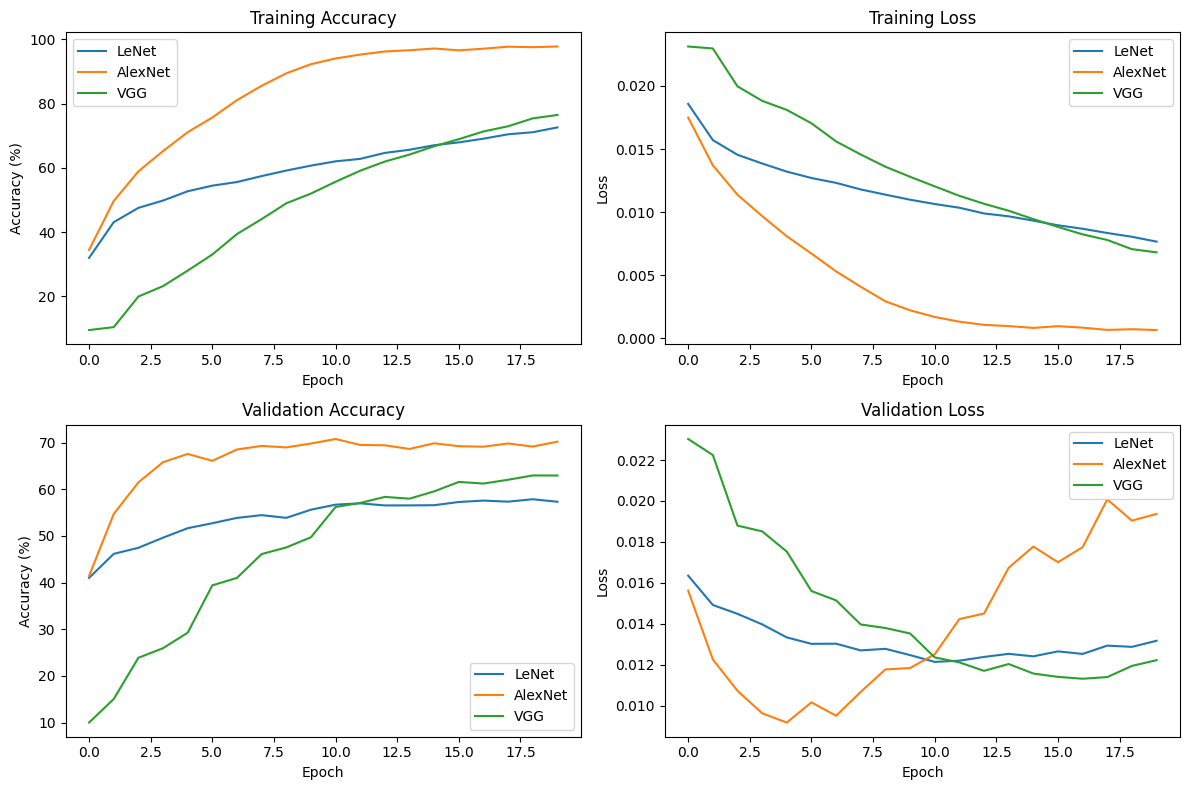

In [3]:
  # Plot the results
plt.figure(figsize=(12, 8))

# Train accuracy
plt.subplot(2, 2, 1)
plt.plot(train_acc_lenet, label='LeNet')
plt.plot(train_acc_alexnet, label='AlexNet')
plt.plot(train_acc_vgg, label='VGG')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Train loss
plt.subplot(2, 2, 2)
plt.plot(train_loss_lenet, label='LeNet')
plt.plot(train_loss_alexnet, label='AlexNet')
plt.plot(train_loss_vgg, label='VGG')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation accuracy
plt.subplot(2, 2, 3)
plt.plot(val_acc_lenet, label='LeNet')
plt.plot(val_acc_alexnet, label='AlexNet')
plt.plot(val_acc_vgg, label='VGG')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Validation loss
plt.subplot(2, 2, 4)
plt.plot(val_loss_lenet, label='LeNet')
plt.plot(val_loss_alexnet, label='AlexNet')
plt.plot(val_loss_vgg, label='VGG')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
